In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms

import matplotlib.pyplot as plt
%matplotlib inline

# MNIST dataset

In [29]:
import pathlib

mnist_root = f"{pathlib.Path.home()}/Projects/AI-ML/datasets/mnist"

train_augmentations = transforms.Compose([
    transforms.RandomRotation(degrees=(-28, 28)),
    transforms.ToTensor() # -> (c, h, w)
])

mnist_train = torchvision.datasets.MNIST(root=mnist_root, train=True, transform=train_augmentations, download=True)

mnist_test = torchvision.datasets.MNIST(root=mnist_root, train=False, transform=transforms.ToTensor(), download=True)

5 torch.Size([1, 28, 28]) total train set: 60000


<function matplotlib.pyplot.show(close=None, block=None)>

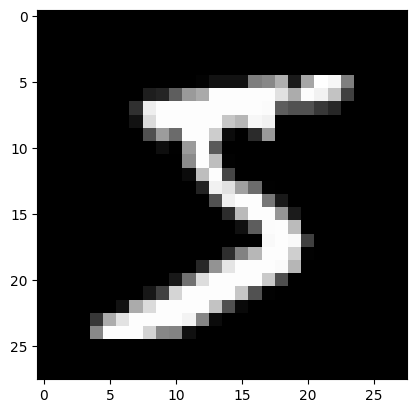

In [3]:
image, label = mnist_train[0]
print(label, image.shape, "total train set:", len(mnist_train))
plt.imshow(image.permute(1, 2, 0), cmap='gray')
plt.show

3750 625
torch.Size([16, 28, 28, 1])


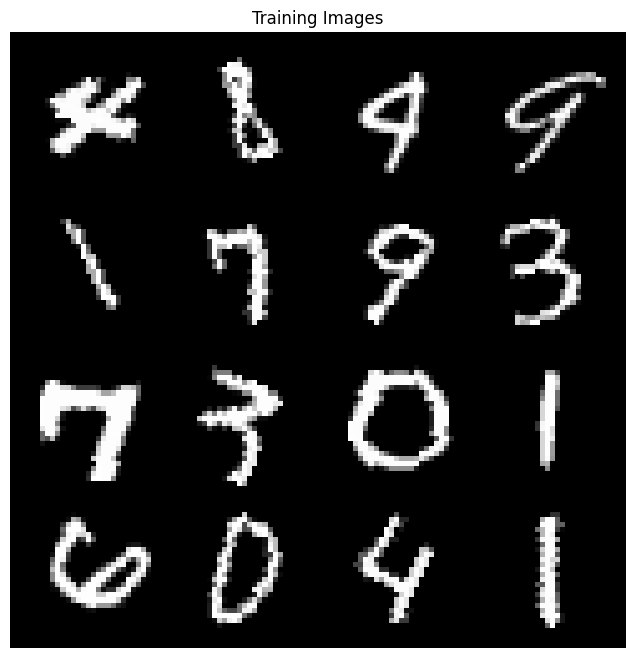

In [30]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

batch_size = 16
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

print(len(train_loader), len(test_loader))

images, labels = next(iter(train_loader))
print(images.permute(0, 2, 3, 1).shape)
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(make_grid(images, nrow=4).permute(1, 2, 0), cmap='gray')
plt.show()

# VAE

![VAE](vae.png)

In [31]:
class Encoder(nn.Module):

    def __init__(self, in_channels, hidden_size, latent_dim) -> None:
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels, hidden_size // 2, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(hidden_size // 2, hidden_size, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(hidden_size),
            nn.LeakyReLU(0.2)
        )

        self.mean_head = nn.Linear(hidden_size * 7 * 7, latent_dim)
        self.std_head = nn.Linear(hidden_size * 7 * 7, latent_dim)

    def forward(self, x):
        x = self.cnn(x)
        x = x.view(x.size(0), -1) # batch_size x flatten
        mu, logsigma = self.mean_head(x), self.std_head(x)
        return mu, logsigma, self.gaussian_sampling(mu, logsigma)
    
    def gaussian_sampling(self, mu, logsigma):
        std = torch.exp(logsigma * 0.5)
        samples = torch.randn_like(std)
        return mu + samples * std

In [32]:
image_channels = 1
hidden_dim = 64
latent_dim = 10

enc = Encoder(image_channels, hidden_dim, latent_dim)

enc(images)

(tensor([[ 0.9972, -0.5924,  0.1262,  0.3721,  0.2096, -0.5307, -0.1282,  0.8640,
          -0.2733,  1.0265],
         [ 0.5572, -0.4577,  0.1436,  0.5801, -0.4140,  0.2987, -0.5020,  0.6287,
          -0.5066, -0.0524],
         [ 0.5084,  0.1306, -0.0503,  0.2645, -0.0255,  0.5554, -0.3897,  0.4206,
          -0.2208,  0.5533],
         [ 0.4499, -0.3262,  0.4444,  0.3876, -0.2245,  0.3097, -0.1986,  0.1710,
          -0.3913,  0.4726],
         [ 0.2516,  0.1727,  0.3082,  0.6790, -0.0453,  0.2655, -0.2698,  0.1823,
          -0.4061,  0.4426],
         [ 0.5127, -0.5410,  0.4336,  0.4839, -0.1636,  0.1544, -0.5018,  0.2832,
          -0.5170,  0.2404],
         [ 0.4100, -0.1184,  0.1508,  0.0597, -0.2463,  0.7755,  0.0063, -0.0758,
          -0.1681,  0.4391],
         [ 0.0120,  0.0401,  0.0618,  0.5265, -0.6094,  0.5080, -0.1486,  0.6272,
          -0.4185,  0.4451],
         [ 0.5381,  0.1883, -0.2877,  0.9098, -0.3150,  0.2169,  0.0168,  0.6108,
           0.4636,  0.5661],
 

In [33]:
class Decoder(nn.Module):

    def __init__(self, latent_dim, hidden_size, in_channels) -> None:
        super().__init__()

        self.linear = nn.Linear(latent_dim, 7 * 7 * hidden_size)
        self.cnn = nn.Sequential(
            nn.ConvTranspose2d(hidden_size, hidden_size // 2, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(hidden_size // 2, in_channels, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )
    
    def forward(self, z):
        x = self.linear(z)
        x = x.view(z.size(0), -1, 7, 7)
        return self.cnn(x)

In [34]:
dec = Decoder(latent_dim, hidden_dim, image_channels)

dec(enc(images)[2])

tensor([[[[0.4618, 0.4337, 0.4762,  ..., 0.4342, 0.4387, 0.4688],
          [0.4169, 0.4210, 0.5000,  ..., 0.4059, 0.4240, 0.4299],
          [0.4377, 0.4486, 0.5125,  ..., 0.3827, 0.4182, 0.4410],
          ...,
          [0.4081, 0.4576, 0.4422,  ..., 0.4063, 0.4761, 0.4188],
          [0.4668, 0.3407, 0.4515,  ..., 0.4651, 0.3876, 0.4635],
          [0.4432, 0.4200, 0.4467,  ..., 0.4526, 0.4380, 0.4541]]],


        [[[0.4685, 0.4664, 0.4685,  ..., 0.4207, 0.4177, 0.4611],
          [0.4148, 0.4155, 0.4577,  ..., 0.3618, 0.3678, 0.4233],
          [0.4576, 0.3853, 0.5010,  ..., 0.4043, 0.4698, 0.4167],
          ...,
          [0.4488, 0.4610, 0.4308,  ..., 0.4523, 0.4255, 0.4878],
          [0.5046, 0.4952, 0.4537,  ..., 0.4346, 0.4005, 0.4373],
          [0.4408, 0.4454, 0.4471,  ..., 0.4328, 0.3622, 0.4636]]],


        [[[0.4529, 0.4315, 0.5036,  ..., 0.4432, 0.4639, 0.5041],
          [0.4065, 0.3720, 0.5145,  ..., 0.4637, 0.3841, 0.4634],
          [0.4224, 0.5391, 0.4949,  ..

# Losses

In [35]:
def KL_divergence(mu, logsigma):
    loss = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())
    return loss

def log_likelihood(x, reconstruction):
    loss = nn.BCELoss(reduction='sum')
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    return KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)

In [36]:
import numpy as np

def train_epoch(encoder, decoder, enc_optimizer, dec_optimizer, criterion, train_loader):
    train_losses_per_epoch = []
    encoder.train()
    decoder.train()
    for x_batch, _ in train_loader:
        mu, logsigma, latent_enc = encoder(x_batch)
        reconstruction = decoder(latent_enc)
        loss = criterion(x_batch, mu, logsigma, reconstruction)

        enc_optimizer.zero_grad()
        dec_optimizer.zero_grad()
        loss.backward()
        enc_optimizer.step()
        dec_optimizer.step()

        train_losses_per_epoch.append(loss.item())

    return np.mean(train_losses_per_epoch), mu, logsigma, reconstruction

In [37]:
def eval_epoch(encoder, decoder, criterion, data_loader):
    val_losses_per_epoch = []
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        for x_val, _ in data_loader:
            mu, logsigma, latent_enc = encoder(x_val)
            reconstruction = decoder(latent_enc)
            loss = criterion(x_val, mu, logsigma, reconstruction)
            val_losses_per_epoch.append(loss.item())
    return np.mean(val_losses_per_epoch), mu, logsigma, reconstruction

In [38]:
def plot_output(encoder, decoder, dataset, size = 5):
    plt.figure(figsize=(18, 6))
    for k in range(size):
        ax = plt.subplot(2, size, k + 1)
        img = dataset[k][0].unsqueeze(0)

        encoder.eval()
        decoder.eval()
        with torch.no_grad():
            mu, logsigma, latent_enc = encoder(img)
            reconstruction = decoder(latent_enc)

        plt.imshow(img.cpu().squeeze().numpy(), cmap='gray')
        plt.axis('off')
        if k == size//2:
            ax.set_title('Real')
        ax = plt.subplot(2, size, k + 1 + size)
        plt.imshow(reconstruction.cpu().squeeze().numpy(), cmap='gray')
        plt.axis('off')

        if k == size//2:
            ax.set_title('Output')
    plt.show()

In [39]:
from tqdm.autonotebook import tqdm

criterion = loss_vae
encoder_optimizer = torch.optim.Adam(enc.parameters(), lr=1e-3)
decoder_optimizer = torch.optim.Adam(dec.parameters(), lr=1e-3)

epochs = 30
loss = {'train_loss':[],'val_loss':[]}
with tqdm(desc="epoch", total=epochs) as pbar_outer:
    for epoch in range(epochs):
        print('* Epoch %d/%d' % (epoch+1, epochs))
        train_loss, mu, logsigma, reconstruction = (train_epoch(enc, dec,
                                                                encoder_optimizer,
                                                                decoder_optimizer,
                                                             criterion, 
                                                             train_loader
                                                             )
        )

        val_loss, mu, logsigma, reconstruction = (eval_epoch(enc, dec, 
                                                          criterion,  
                                                          test_loader)
        )
        pbar_outer.update(1)

        loss['train_loss'].append(train_loss)
        loss['val_loss'].append(val_loss)
        print('%d / %d - loss: %f val_loss: %f' % (epoch+1, epochs, train_loss, val_loss))

epoch:   0%|          | 0/30 [00:00<?, ?it/s]

* Epoch 1/30


epoch:   3%|▎         | 1/30 [00:45<21:50, 45.21s/it]

1 / 30 - loss: 2233.061238 val_loss: 1927.039289
* Epoch 2/30


epoch:   7%|▋         | 2/30 [01:29<20:45, 44.47s/it]

2 / 30 - loss: 2023.550316 val_loss: 1860.857618
* Epoch 3/30


epoch:  10%|█         | 3/30 [02:11<19:28, 43.29s/it]

3 / 30 - loss: 1979.642778 val_loss: 1822.739690
* Epoch 4/30


epoch:  13%|█▎        | 4/30 [02:55<18:54, 43.63s/it]

4 / 30 - loss: 1957.024872 val_loss: 1810.129198
* Epoch 5/30


epoch:  17%|█▋        | 5/30 [03:36<17:51, 42.87s/it]

5 / 30 - loss: 1940.465269 val_loss: 1788.907293
* Epoch 6/30


epoch:  20%|██        | 6/30 [04:20<17:16, 43.20s/it]

6 / 30 - loss: 1930.824487 val_loss: 1787.984091
* Epoch 7/30


epoch:  23%|██▎       | 7/30 [05:03<16:30, 43.08s/it]

7 / 30 - loss: 1921.490295 val_loss: 1779.697951
* Epoch 8/30


epoch:  27%|██▋       | 8/30 [05:46<15:47, 43.09s/it]

8 / 30 - loss: 1914.830619 val_loss: 1773.367785
* Epoch 9/30


epoch:  30%|███       | 9/30 [06:33<15:28, 44.22s/it]

9 / 30 - loss: 1910.664338 val_loss: 1766.288956
* Epoch 10/30


epoch:  33%|███▎      | 10/30 [07:19<14:56, 44.84s/it]

10 / 30 - loss: 1905.834175 val_loss: 1771.318888
* Epoch 11/30


epoch:  37%|███▋      | 11/30 [08:06<14:27, 45.65s/it]

11 / 30 - loss: 1901.451982 val_loss: 1771.741042
* Epoch 12/30


epoch:  40%|████      | 12/30 [08:57<14:10, 47.23s/it]

12 / 30 - loss: 1897.998474 val_loss: 1767.826880
* Epoch 13/30


epoch:  43%|████▎     | 13/30 [09:45<13:27, 47.52s/it]

13 / 30 - loss: 1895.482756 val_loss: 1751.770213
* Epoch 14/30


epoch:  47%|████▋     | 14/30 [10:34<12:46, 47.88s/it]

14 / 30 - loss: 1892.623291 val_loss: 1754.378374
* Epoch 15/30


epoch:  50%|█████     | 15/30 [11:25<12:12, 48.85s/it]

15 / 30 - loss: 1890.235533 val_loss: 1758.475126
* Epoch 16/30


epoch:  53%|█████▎    | 16/30 [12:14<11:25, 48.95s/it]

16 / 30 - loss: 1888.302134 val_loss: 1751.276747
* Epoch 17/30


epoch:  57%|█████▋    | 17/30 [12:59<10:21, 47.77s/it]

17 / 30 - loss: 1885.819303 val_loss: 1748.750253
* Epoch 18/30


epoch:  60%|██████    | 18/30 [13:47<09:32, 47.67s/it]

18 / 30 - loss: 1883.806128 val_loss: 1739.870570
* Epoch 19/30


epoch:  63%|██████▎   | 19/30 [14:33<08:37, 47.06s/it]

19 / 30 - loss: 1882.389422 val_loss: 1742.185555
* Epoch 20/30


epoch:  67%|██████▋   | 20/30 [15:19<07:49, 46.92s/it]

20 / 30 - loss: 1880.467602 val_loss: 1742.980263
* Epoch 21/30


epoch:  70%|███████   | 21/30 [16:06<07:01, 46.86s/it]

21 / 30 - loss: 1878.795025 val_loss: 1739.678292
* Epoch 22/30


epoch:  73%|███████▎  | 22/30 [16:52<06:14, 46.77s/it]

22 / 30 - loss: 1878.600638 val_loss: 1745.929066
* Epoch 23/30


epoch:  77%|███████▋  | 23/30 [17:44<05:38, 48.33s/it]

23 / 30 - loss: 1876.451435 val_loss: 1740.400889
* Epoch 24/30


epoch:  80%|████████  | 24/30 [18:30<04:45, 47.51s/it]

24 / 30 - loss: 1875.644309 val_loss: 1745.669946
* Epoch 25/30


epoch:  83%|████████▎ | 25/30 [19:16<03:55, 47.19s/it]

25 / 30 - loss: 1875.402414 val_loss: 1739.681906
* Epoch 26/30


epoch:  87%|████████▋ | 26/30 [20:03<03:07, 46.91s/it]

26 / 30 - loss: 1873.826261 val_loss: 1735.150581
* Epoch 27/30


epoch:  90%|█████████ | 27/30 [20:51<02:22, 47.37s/it]

27 / 30 - loss: 1872.434178 val_loss: 1731.082575
* Epoch 28/30


epoch:  93%|█████████▎| 28/30 [21:41<01:36, 48.01s/it]

28 / 30 - loss: 1871.391013 val_loss: 1729.873638
* Epoch 29/30


epoch:  97%|█████████▋| 29/30 [22:27<00:47, 47.47s/it]

29 / 30 - loss: 1871.151178 val_loss: 1729.454326
* Epoch 30/30


epoch: 100%|██████████| 30/30 [23:13<00:00, 46.46s/it]

30 / 30 - loss: 1869.055394 val_loss: 1729.120974


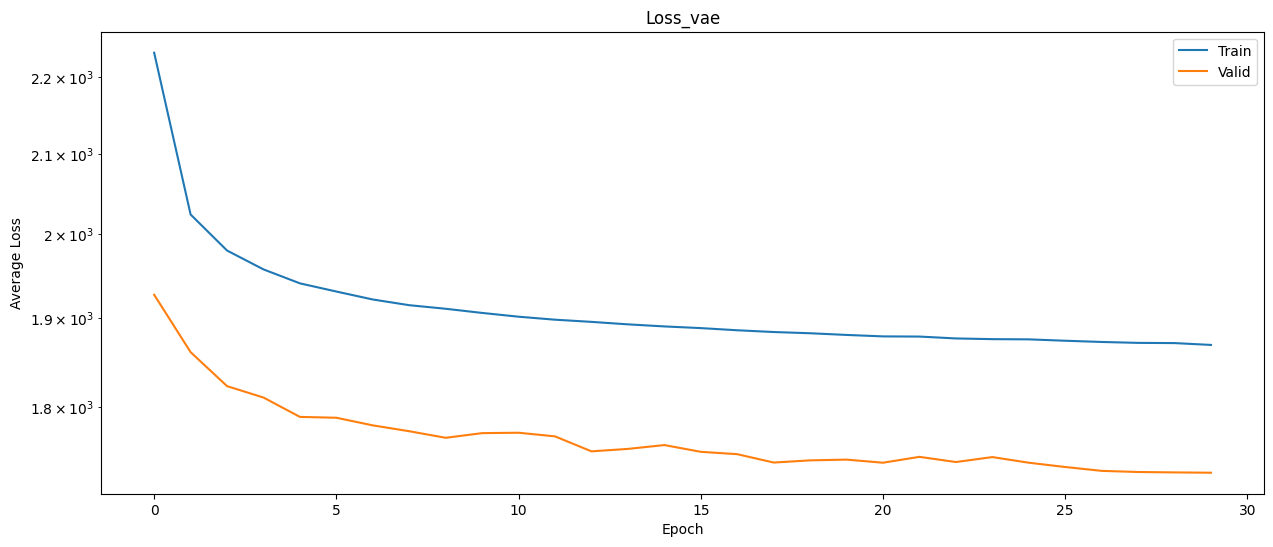

In [40]:
plt.figure(figsize=(15, 6))
plt.semilogy(loss['train_loss'], label='Train')
plt.semilogy(loss['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.legend()
plt.title('Loss_vae')
plt.show()

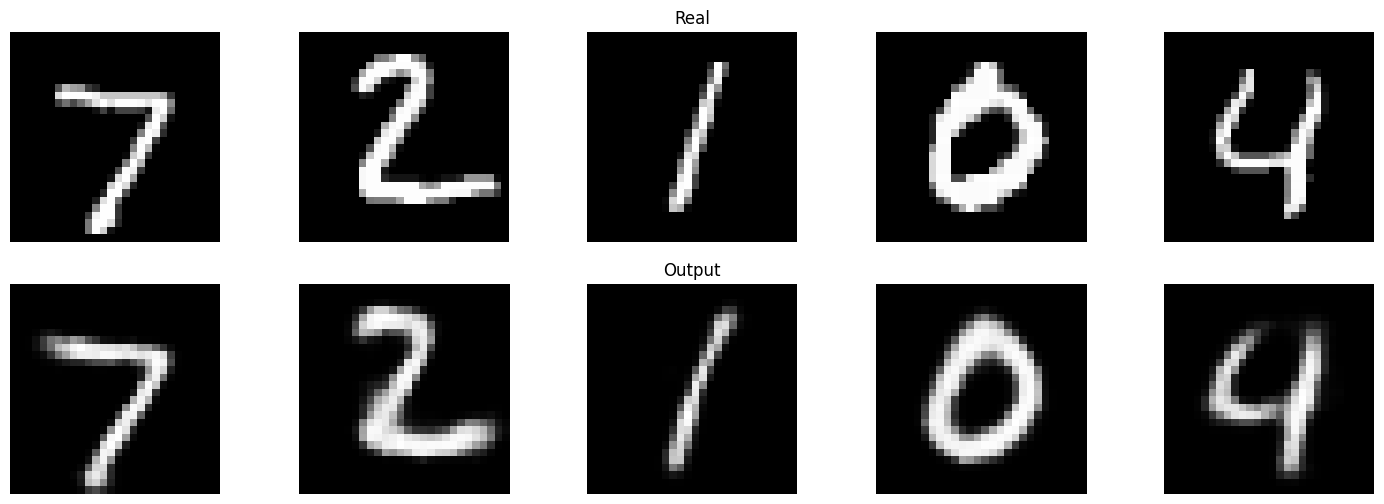

In [42]:
plot_output(enc, dec, mnist_test, size = 5)

In [43]:
import pandas as pd

latent_space = []
for image, label in tqdm(mnist_test):

    enc.eval()
    with torch.no_grad():
        _, _, latent = enc(image.unsqueeze(0))

    latent = latent.flatten().numpy()
    sample = {f"Encoded_{i}": encoded for i, encoded in enumerate(latent)}
    sample['label'] = label
    latent_space.append(sample)

latent_space = pd.DataFrame(latent_space)
latent_space['label'] = latent_space['label'].astype(int)

latent_space.head()

100%|██████████| 10000/10000 [00:02<00:00, 4268.66it/s]


,Encoded_0,Encoded_1,Encoded_2,Encoded_3,Encoded_4,Encoded_5,Encoded_6,Encoded_7,Encoded_8,Encoded_9,label
0,-0.921201,-2.564049,1.487455,-0.321971,-0.261187,0.576182,-1.685895,-1.001839,0.401762,0.293909,7
1,1.208606,0.198263,-2.439524,-0.741946,1.115053,0.991879,0.012773,1.580135,-0.652836,-0.730556,2
2,-0.566927,0.696969,-0.362513,0.478960,2.226550,0.117652,-0.707287,-0.108807,1.241907,-0.332442,1
3,0.505950,-0.276061,0.058481,1.240765,-0.914398,-0.717445,0.229043,-0.181948,-0.492567,1.550834,0
4,-2.736150,1.263938,1.057390,-0.171905,-0.260584,-0.699050,0.236340,0.202628,-0.910173,-0.429086,4


In [44]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
digits_embedded = tsne.fit_transform(latent_space.drop(['label'],axis=1))

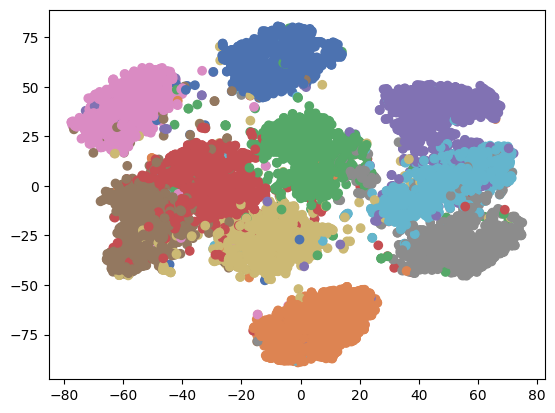

In [46]:
import numpy as np

import seaborn as sns

from matplotlib.colors import ListedColormap

PALETTE = sns.color_palette('deep', n_colors=10)
CMAP = ListedColormap(PALETTE.as_hex())



plt.scatter(digits_embedded[:, 0], digits_embedded[:, 1],
            c=latent_space['label'], cmap=CMAP)
                      
plt.show()

In [56]:
class ConditionalEncoder(nn.Module):

    def __init__(self, in_channels, hidden_size, latent_dim) -> None:
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels, hidden_size // 2, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(hidden_size // 2, hidden_size, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(hidden_size),
            nn.LeakyReLU(0.2)
        )

        self.label_enc = nn.Embedding(10, hidden_size)
        self.mean_head = nn.Linear(hidden_size * 7 * 7 + hidden_size, latent_dim)
        self.std_head = nn.Linear(hidden_size * 7 * 7 + hidden_size, latent_dim)

    def forward(self, x, y):
        x = self.cnn(x)
        y = self.label_enc(y)
        hidden = torch.cat((x.view(x.size(0), -1), y), dim=1)  # batch_size x flatten
        mu, logsigma = self.mean_head(hidden), self.std_head(hidden)
        return mu, logsigma, self.gaussian_sampling(mu, logsigma)
    
    def gaussian_sampling(self, mu, logsigma):
        std = torch.exp(logsigma * 0.5)
        samples = torch.randn_like(std)
        return mu + samples * std

In [57]:
print(images.shape, labels.shape)
c_enc = ConditionalEncoder(image_channels, hidden_dim, latent_dim)
c_enc(images, labels)

torch.Size([16, 1, 28, 28]) torch.Size([16])


(tensor([[ 2.6212e-01, -1.3905e-01, -2.5703e-01,  1.0830e-01, -8.3394e-02,
          -5.4074e-01, -2.4493e-01, -3.9375e-01,  5.3013e-01,  2.9606e-01],
         [ 3.6460e-01,  1.2987e-01,  8.1337e-01,  2.4196e-01,  2.2417e-01,
          -4.0016e-01,  2.9338e-01, -1.0218e+00,  4.2034e-01,  2.9923e-01],
         [ 3.4248e-01, -4.3154e-01,  5.2858e-01, -1.9093e-01,  1.6562e-01,
          -2.8578e-01,  3.6268e-01, -6.0887e-01,  3.4463e-01,  1.8566e-01],
         [ 1.4201e-01, -1.6285e-01,  4.1567e-01,  6.7468e-02, -2.6876e-01,
          -3.0796e-01,  4.1396e-01, -6.1196e-01,  5.2987e-01,  4.1788e-01],
         [-2.7386e-01,  1.2881e-01,  9.1455e-03,  4.8151e-01, -1.9867e-01,
          -2.7920e-01,  3.6815e-01, -5.1461e-01, -3.8374e-02,  3.8909e-01],
         [ 3.4778e-01, -7.4818e-02,  1.8562e-01, -3.2832e-01,  1.8822e-01,
          -6.5838e-01, -9.2061e-02, -4.9138e-01,  3.9916e-01,  7.1536e-01],
         [ 7.1634e-02,  3.7132e-02,  1.9053e-01,  3.6192e-02, -1.8898e-01,
          -5.1366e-

In [55]:
labels

tensor([4, 8, 4, 9, 1, 7, 9, 3, 7, 3, 0, 1, 6, 0, 4, 1])

In [61]:
class ConditionalDecoder(nn.Module):

    def __init__(self, latent_dim, hidden_size, in_channels) -> None:
        super().__init__()

        self.label_enc = nn.Embedding(10, latent_dim)
        self.linear = nn.Linear(latent_dim * 2, 7 * 7 * hidden_size)
        self.cnn = nn.Sequential(
            nn.ConvTranspose2d(hidden_size, hidden_size // 2, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(hidden_size // 2, in_channels, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )
    
    def forward(self, z, y):
        y = self.label_enc(y)
        x = torch.cat((z, y), dim=1)
        x = self.linear(x)
        x = x.view(z.size(0), -1, 7, 7)
        return self.cnn(x)

In [62]:
c_dec = ConditionalDecoder(latent_dim, hidden_dim, image_channels)
c_dec(c_enc(images, labels)[2], labels)

tensor([[[[0.4614, 0.5499, 0.4700,  ..., 0.5239, 0.4755, 0.5287],
          [0.5004, 0.4261, 0.5005,  ..., 0.4749, 0.5211, 0.4380],
          [0.4776, 0.5428, 0.4617,  ..., 0.4851, 0.5343, 0.5173],
          ...,
          [0.4941, 0.4349, 0.5541,  ..., 0.4086, 0.4518, 0.5114],
          [0.4670, 0.4714, 0.5327,  ..., 0.5081, 0.4534, 0.5204],
          [0.5009, 0.4996, 0.5313,  ..., 0.5012, 0.4942, 0.4980]]],


        [[[0.5232, 0.4940, 0.4791,  ..., 0.5365, 0.4513, 0.5285],
          [0.4702, 0.4846, 0.5154,  ..., 0.5058, 0.5514, 0.4551],
          [0.5259, 0.4300, 0.4801,  ..., 0.4877, 0.4425, 0.4959],
          ...,
          [0.4606, 0.4680, 0.5345,  ..., 0.4327, 0.5429, 0.4765],
          [0.5120, 0.4612, 0.4813,  ..., 0.3745, 0.5182, 0.5019],
          [0.4853, 0.4904, 0.4915,  ..., 0.4677, 0.4839, 0.4974]]],


        [[[0.4825, 0.5287, 0.4817,  ..., 0.5120, 0.4773, 0.5352],
          [0.5118, 0.4854, 0.5146,  ..., 0.4856, 0.4971, 0.4687],
          [0.5078, 0.5330, 0.5103,  ..

In [66]:
import numpy as np

def train_epoch(encoder, decoder, enc_optimizer, dec_optimizer, criterion, train_loader):
    train_losses_per_epoch = []
    encoder.train()
    decoder.train()
    for x_batch, y_batch in train_loader:
        mu, logsigma, latent_enc = encoder(x_batch, y_batch)
        reconstruction = decoder(latent_enc, y_batch)
        loss = criterion(x_batch, mu, logsigma, reconstruction)

        enc_optimizer.zero_grad()
        dec_optimizer.zero_grad()
        loss.backward()
        enc_optimizer.step()
        dec_optimizer.step()

        train_losses_per_epoch.append(loss.item())

    return np.mean(train_losses_per_epoch), mu, logsigma, reconstruction

In [67]:
def eval_epoch(encoder, decoder, criterion, data_loader):
    val_losses_per_epoch = []
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        for x_val, y_val in data_loader:
            mu, logsigma, latent_enc = encoder(x_val, y_val)
            reconstruction = decoder(latent_enc, y_val)
            loss = criterion(x_val, mu, logsigma, reconstruction)
            val_losses_per_epoch.append(loss.item())
    return np.mean(val_losses_per_epoch), mu, logsigma, reconstruction

In [68]:
from tqdm.autonotebook import tqdm

criterion = loss_vae
encoder_optimizer = torch.optim.Adam(c_enc.parameters(), lr=1e-3)
decoder_optimizer = torch.optim.Adam(c_dec.parameters(), lr=1e-3)

epochs = 30
loss = {'train_loss':[],'val_loss':[]}
with tqdm(desc="epoch", total=epochs) as pbar_outer:
    for epoch in range(epochs):
        print('* Epoch %d/%d' % (epoch+1, epochs))
        train_loss, mu, logsigma, reconstruction = (train_epoch(c_enc, c_dec,
                                                                encoder_optimizer,
                                                                decoder_optimizer,
                                                             criterion, 
                                                             train_loader
                                                             )
        )

        val_loss, mu, logsigma, reconstruction = (eval_epoch(c_enc, c_dec, 
                                                          criterion,  
                                                          test_loader)
        )
        pbar_outer.update(1)

        loss['train_loss'].append(train_loss)
        loss['val_loss'].append(val_loss)
        print('%d / %d - loss: %f val_loss: %f' % (epoch+1, epochs, train_loss, val_loss))

epoch:   0%|          | 0/30 [00:00<?, ?it/s]

* Epoch 1/30


epoch:   3%|▎         | 1/30 [00:50<24:24, 50.49s/it]

1 / 30 - loss: 2148.856011 val_loss: 1819.568556
* Epoch 2/30


epoch:   7%|▋         | 2/30 [01:41<23:47, 51.00s/it]

2 / 30 - loss: 1920.681358 val_loss: 1756.649537
* Epoch 3/30


epoch:  10%|█         | 3/30 [02:30<22:29, 49.99s/it]

3 / 30 - loss: 1879.596418 val_loss: 1714.057389
* Epoch 4/30


epoch:  13%|█▎        | 4/30 [03:23<22:04, 50.95s/it]

4 / 30 - loss: 1856.132553 val_loss: 1709.298955
* Epoch 5/30


epoch:  17%|█▋        | 5/30 [04:13<21:11, 50.86s/it]

5 / 30 - loss: 1840.581804 val_loss: 1702.354701
* Epoch 6/30


epoch:  20%|██        | 6/30 [05:03<20:14, 50.60s/it]

6 / 30 - loss: 1829.995301 val_loss: 1683.111869
* Epoch 7/30


epoch:  23%|██▎       | 7/30 [05:54<19:27, 50.75s/it]

7 / 30 - loss: 1821.210371 val_loss: 1673.370779
* Epoch 8/30


epoch:  27%|██▋       | 8/30 [06:46<18:40, 50.95s/it]

8 / 30 - loss: 1815.316977 val_loss: 1661.867405
* Epoch 9/30


epoch:  30%|███       | 9/30 [07:38<17:56, 51.26s/it]

9 / 30 - loss: 1807.705082 val_loss: 1662.725265
* Epoch 10/30


epoch:  33%|███▎      | 10/30 [08:31<17:17, 51.86s/it]

10 / 30 - loss: 1803.630558 val_loss: 1656.258086
* Epoch 11/30


epoch:  37%|███▋      | 11/30 [09:24<16:30, 52.15s/it]

11 / 30 - loss: 1798.691035 val_loss: 1656.617235
* Epoch 12/30


epoch:  40%|████      | 12/30 [10:16<15:38, 52.17s/it]

12 / 30 - loss: 1795.417544 val_loss: 1648.990618
* Epoch 13/30


epoch:  43%|████▎     | 13/30 [11:09<14:49, 52.34s/it]

13 / 30 - loss: 1792.280703 val_loss: 1640.571009
* Epoch 14/30


epoch:  47%|████▋     | 14/30 [12:02<14:04, 52.78s/it]

14 / 30 - loss: 1789.707125 val_loss: 1653.231743
* Epoch 15/30


epoch:  50%|█████     | 15/30 [12:54<13:06, 52.44s/it]

15 / 30 - loss: 1786.880362 val_loss: 1644.052405
* Epoch 16/30


epoch:  53%|█████▎    | 16/30 [13:44<12:03, 51.70s/it]

16 / 30 - loss: 1784.268818 val_loss: 1641.943435
* Epoch 17/30


epoch:  57%|█████▋    | 17/30 [14:35<11:08, 51.39s/it]

17 / 30 - loss: 1782.075575 val_loss: 1647.389782
* Epoch 18/30


epoch:  60%|██████    | 18/30 [15:24<10:09, 50.83s/it]

18 / 30 - loss: 1780.660037 val_loss: 1639.321433
* Epoch 19/30


epoch:  63%|██████▎   | 19/30 [16:12<09:07, 49.76s/it]

19 / 30 - loss: 1778.539408 val_loss: 1638.340592
* Epoch 20/30


epoch:  67%|██████▋   | 20/30 [16:59<08:09, 48.92s/it]

20 / 30 - loss: 1776.706889 val_loss: 1635.204909
* Epoch 21/30


epoch:  70%|███████   | 21/30 [17:52<07:32, 50.27s/it]

21 / 30 - loss: 1775.148531 val_loss: 1633.488073
* Epoch 22/30


epoch:  73%|███████▎  | 22/30 [18:43<06:44, 50.62s/it]

22 / 30 - loss: 1773.086052 val_loss: 1628.039240
* Epoch 23/30


epoch:  77%|███████▋  | 23/30 [19:33<05:53, 50.45s/it]

23 / 30 - loss: 1773.952593 val_loss: 1632.764658
* Epoch 24/30


epoch:  80%|████████  | 24/30 [20:23<05:01, 50.24s/it]

24 / 30 - loss: 1771.874016 val_loss: 1631.430127
* Epoch 25/30


epoch:  83%|████████▎ | 25/30 [21:13<04:11, 50.21s/it]

25 / 30 - loss: 1770.806854 val_loss: 1626.287369
* Epoch 26/30


epoch:  87%|████████▋ | 26/30 [22:03<03:20, 50.21s/it]

26 / 30 - loss: 1769.026945 val_loss: 1632.680390
* Epoch 27/30


epoch:  90%|█████████ | 27/30 [22:54<02:30, 50.24s/it]

27 / 30 - loss: 1768.385651 val_loss: 1626.110893
* Epoch 28/30


epoch:  93%|█████████▎| 28/30 [23:44<01:40, 50.20s/it]

28 / 30 - loss: 1767.823854 val_loss: 1637.959533
* Epoch 29/30


epoch:  97%|█████████▋| 29/30 [24:34<00:50, 50.28s/it]

29 / 30 - loss: 1765.868808 val_loss: 1621.135253
* Epoch 30/30


epoch: 100%|██████████| 30/30 [25:25<00:00, 50.85s/it]

30 / 30 - loss: 1765.724407 val_loss: 1618.520571


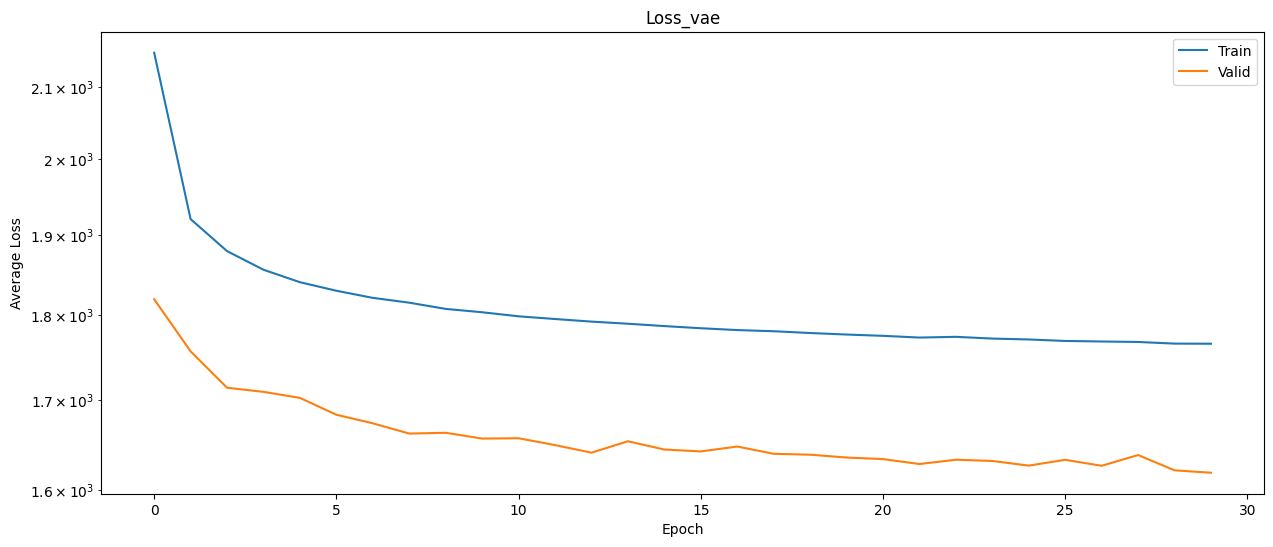

In [69]:
plt.figure(figsize=(15, 6))
plt.semilogy(loss['train_loss'], label='Train')
plt.semilogy(loss['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.legend()
plt.title('Loss_vae')
plt.show()

In [71]:
def latent_sampling(n_samples):
    latent_samples = torch.randn(n_samples*10, latent_dim)
    labels = torch.tensor([[i] * n_samples for i in range(10)], dtype=torch.long).view(-1)
    with torch.no_grad():
        constructeds = c_dec(latent_samples, labels)
        return constructeds.view(-1, 1, 28, 28)

constructeds = latent_sampling(10)
constructeds.shape

torch.Size([100, 1, 28, 28])

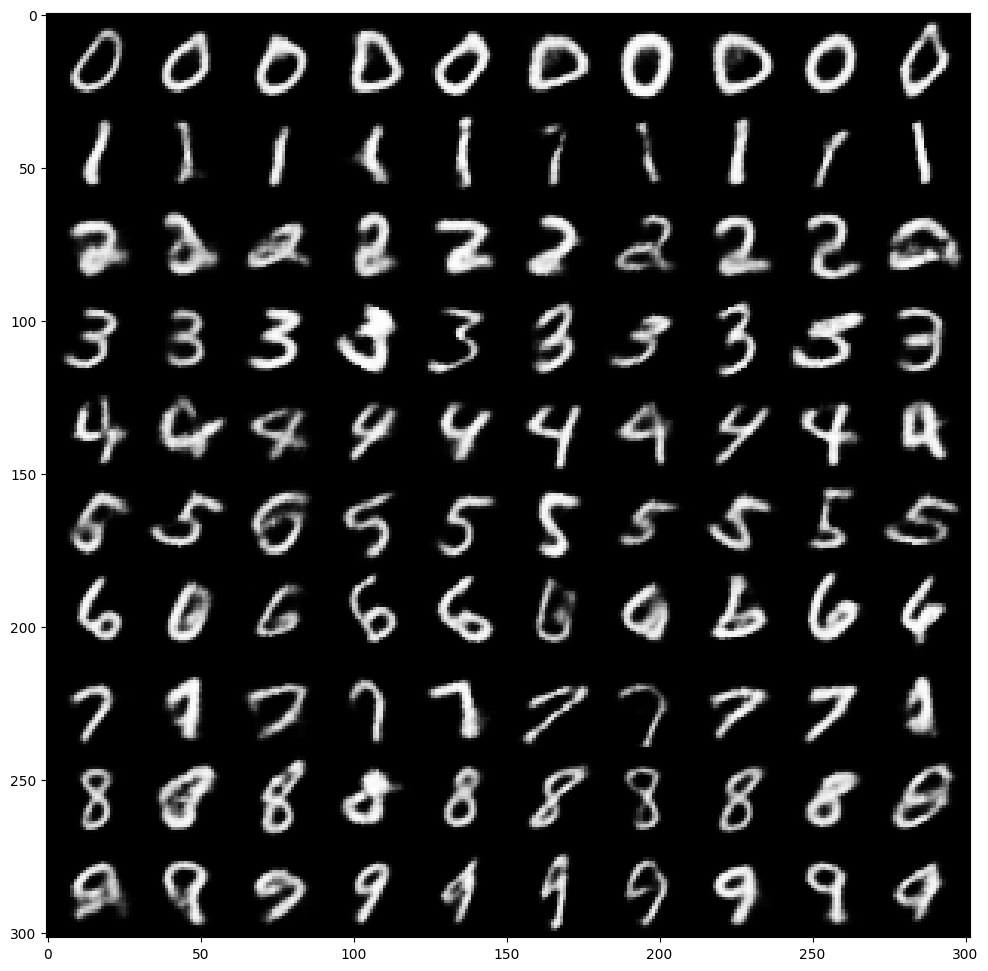

In [72]:
from torchvision.utils import make_grid

def plot_samples(constructeds):
    plt.figure(figsize=(12, 12))
    plt.imshow(make_grid(constructeds, nrow=10).permute(1, 2, 0), cmap='gray')
    plt.show()

plot_samples(constructeds)

In [73]:
import pandas as pd

latent_space = []
for image, label in tqdm(mnist_test):

    c_enc.eval()
    with torch.no_grad():
        _, _, latent = c_enc(image.unsqueeze(0), torch.tensor([label]))

    latent = latent.flatten().numpy()
    sample = {f"Encoded_{i}": encoded for i, encoded in enumerate(latent)}
    sample['label'] = label
    latent_space.append(sample)

latent_space = pd.DataFrame(latent_space)
latent_space['label'] = latent_space['label'].astype(int)

latent_space.head()

100%|██████████| 10000/10000 [00:02<00:00, 4062.27it/s]


,Encoded_0,Encoded_1,Encoded_2,Encoded_3,Encoded_4,Encoded_5,Encoded_6,Encoded_7,Encoded_8,Encoded_9,label
0,-0.133181,-1.472917,0.476421,1.955614,-0.610504,-0.253537,1.141260,0.010466,-1.055471,0.429957,7
1,-0.360237,0.080952,-1.248950,0.215769,-2.327747,-0.589125,-2.230131,1.301232,0.491863,2.021258,2
2,0.885142,-0.494462,1.537552,-1.113670,-0.098267,0.318742,-0.487485,-0.059066,-0.998052,0.957844,1
3,0.522132,0.060772,-0.266354,-0.205114,1.615534,-0.484100,-0.795436,0.159650,0.115511,-0.400860,0
4,-0.077125,1.851461,1.656249,0.050030,-1.311370,0.310585,1.265555,0.731468,-0.800675,-0.567509,4


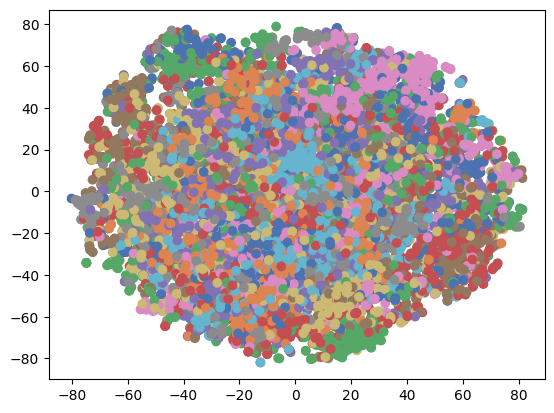

In [74]:

tsne = TSNE(n_components=2)
digits_embedded = tsne.fit_transform(latent_space.drop(['label'],axis=1))


PALETTE = sns.color_palette('deep', n_colors=10)
CMAP = ListedColormap(PALETTE.as_hex())



plt.scatter(digits_embedded[:, 0], digits_embedded[:, 1],
            c=latent_space['label'], cmap=CMAP)
                      
plt.show()